In [16]:
import scanpy as sc
import surgeon

In [2]:
sc.settings.set_figure_params(dpi=200)

In [3]:
condition_key = "batch"
cell_type_key = 'celltype'
target_condition = "Batch4"

# Loading four Toy datasets and data preparation

In [4]:
adata = sc.read("./data/toy/toy_normalized.h5ad")
adata

AnnData object with n_obs × n_vars = 20000 × 2000 
    obs: 'batch', 'celltype', 'n_counts'

## Number of cells in each batch

In [5]:
adata.obs[condition_key].value_counts()

Batch4    5000
Batch3    5000
Batch2    5000
Batch1    5000
Name: batch, dtype: int64

## visualization  of the original data

In [6]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/mohsen/.local/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 20 separate connected components using meta-embedding (experimental)
  n_components


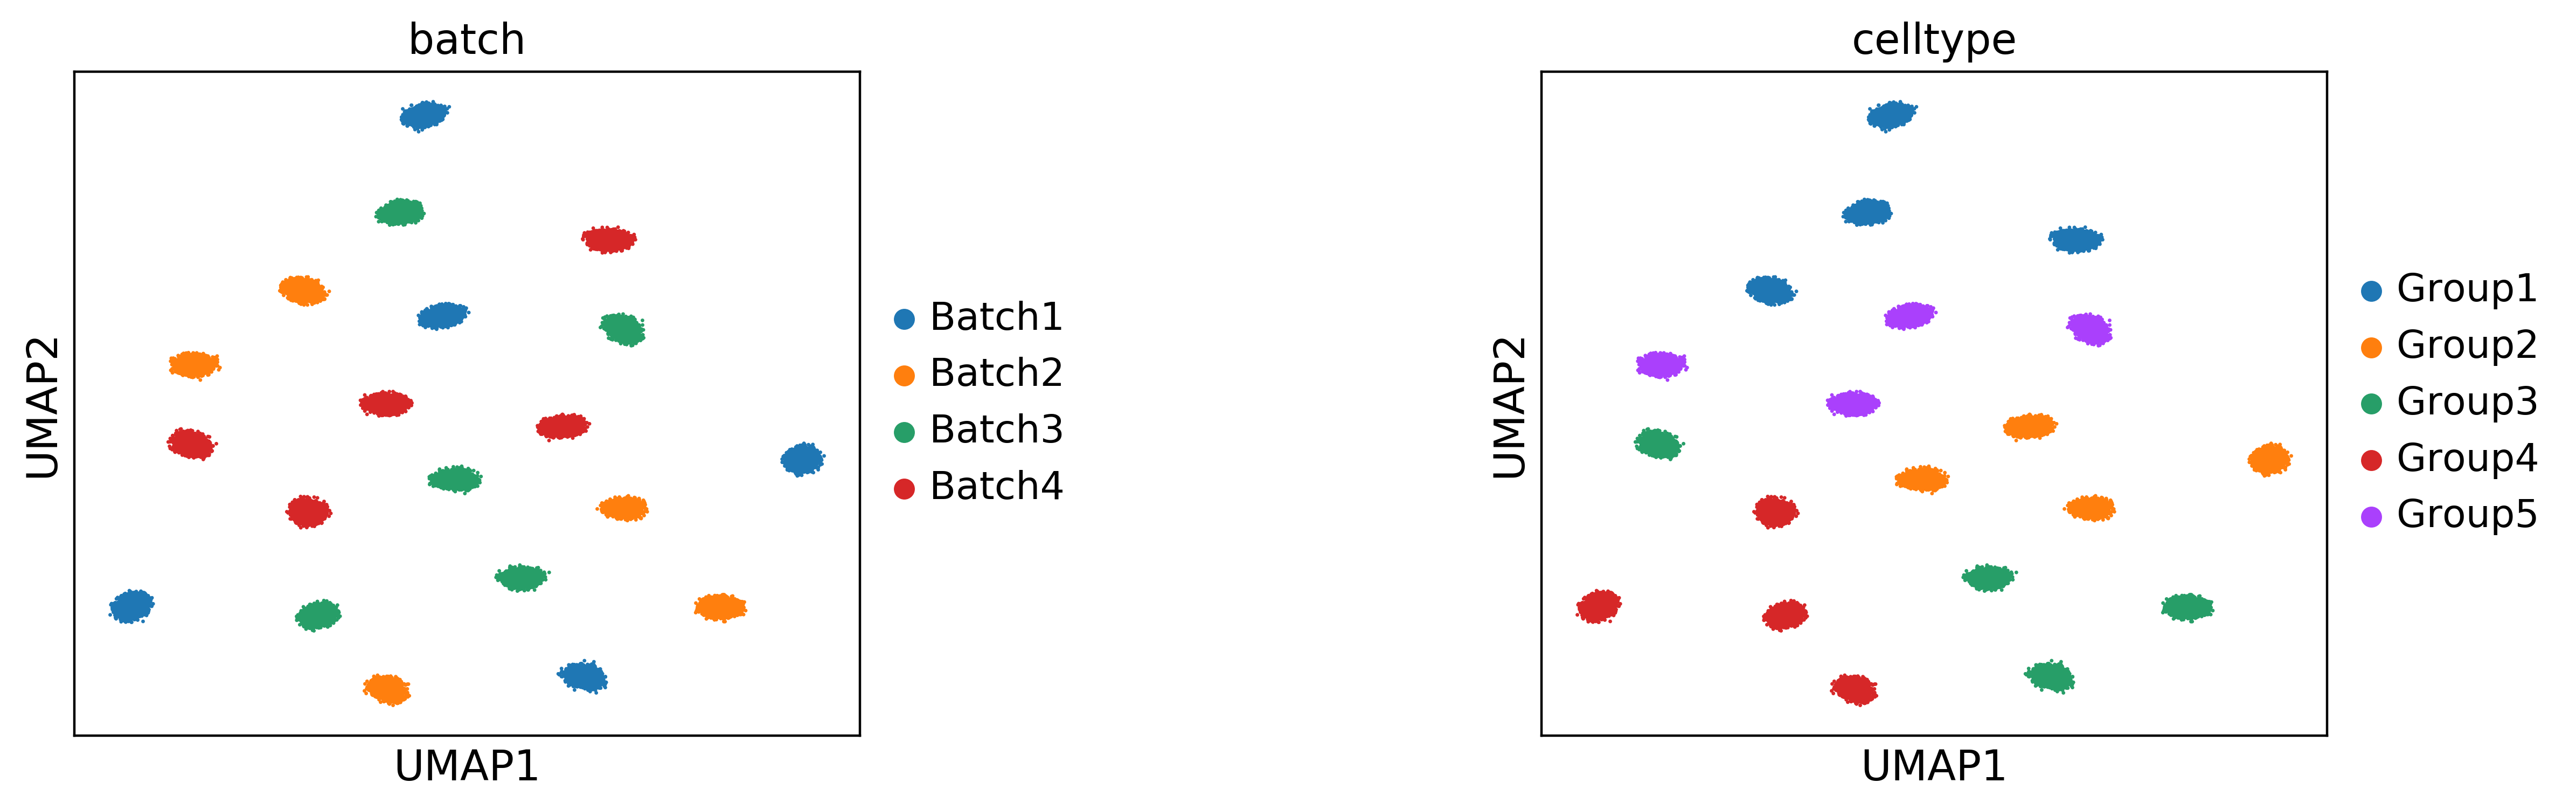

In [7]:
sc.pl.umap(adata, color=[condition_key, cell_type_key], wspace=0.7)

## Now we leave out one study (SS2) for training the newtork

In [8]:
adata_for_training = adata[adata.obs[condition_key] != target_condition]
adata_for_training

View of AnnData object with n_obs × n_vars = 15000 × 2000 
    obs: 'batch', 'celltype', 'n_counts'
    uns: 'neighbors', 'batch_colors', 'celltype_colors'
    obsm: 'X_pca', 'X_umap'

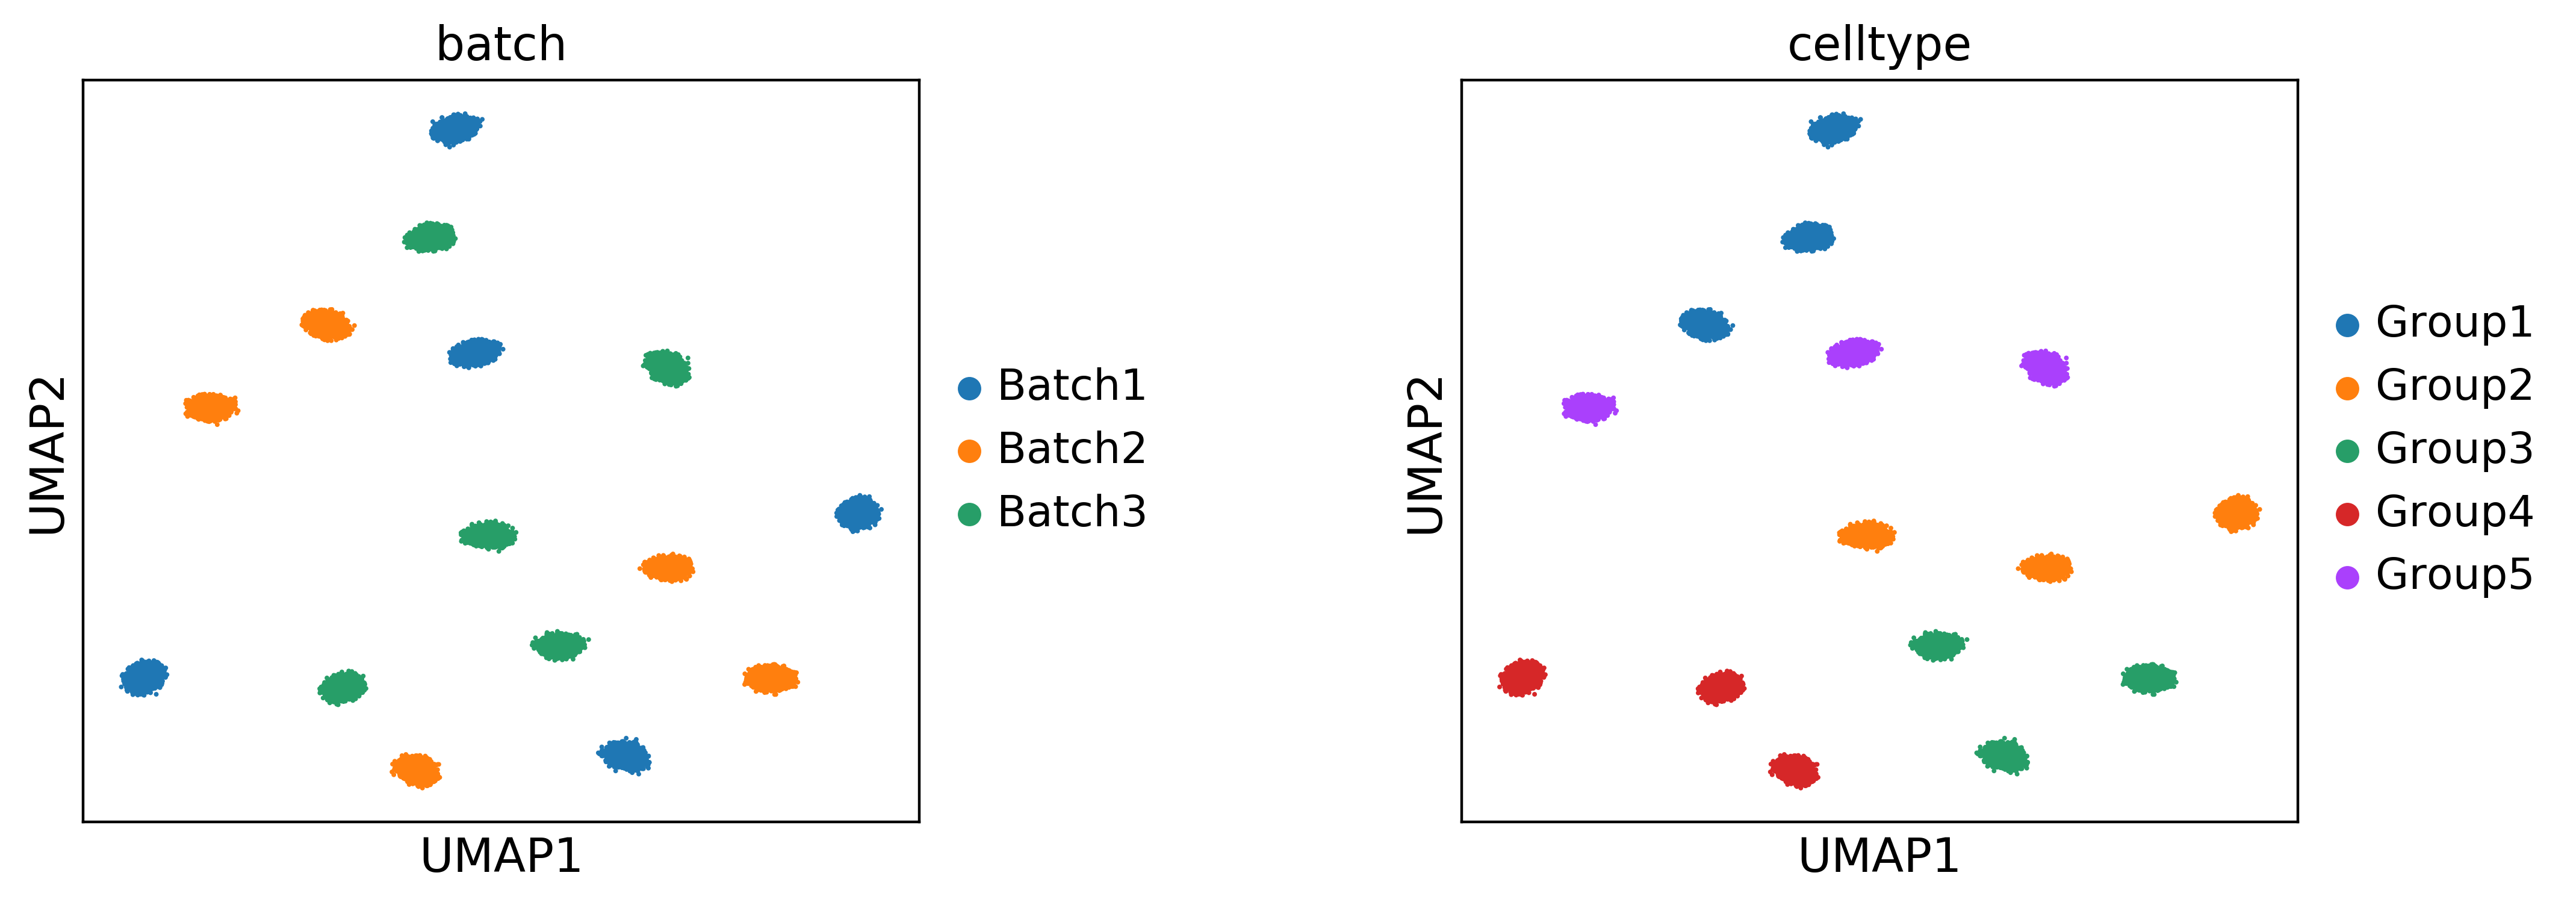

In [9]:
sc.pl.umap(adata_for_training, color=[condition_key, cell_type_key], wspace=0.5)

In [10]:
adata_out_of_sample = adata[adata.obs[condition_key] == target_condition]
adata_out_of_sample

View of AnnData object with n_obs × n_vars = 5000 × 2000 
    obs: 'batch', 'celltype', 'n_counts'
    uns: 'neighbors', 'batch_colors', 'celltype_colors'
    obsm: 'X_pca', 'X_umap'

## Train/Test Split

In [11]:
train_adata, valid_adata = surgeon.utils.train_test_split(adata_for_training, 0.85)

In [12]:
train_adata.shape, valid_adata.shape

((12750, 2000), (2250, 2000))

In [13]:
n_conditions = len(train_adata.obs[condition_key].unique().tolist())

# Create & Train model with training data

In [14]:
network = surgeon.archs.CVAE(x_dimension=train_adata.shape[1], 
                             z_dimension=20,
                             n_conditions=n_conditions,
                             lr=0.001,
                             alpha=0.001,
                             eta=1.0,
                             clip_value=100.0,
                             loss_fn='mse',
                             model_path="./models/CVAE/Toy_normalized/",
                             dropout_rate=0.2,
                             output_activation='relu')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 2000)         0                                            
__________________________________________________________________________________________________
encoder_labels (InputLayer)     (None, 3)            0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 2003)         0           data[0][0]                       
                                                                 encoder_labels[0][0]             
_____________________

## We assign each study to a numerical label 

In [15]:
conditions = adata.obs[condition_key].unique().tolist()
target_conditions = [target_condition]
condition_encoder = surgeon.utils.create_dictionary(conditions, target_conditions)
condition_encoder

{'Batch1': 0, 'Batch2': 1, 'Batch3': 2}

## Training the network

In [17]:
network.train(train_adata,
              valid_adata, 
              condition_key=condition_key,
              le=condition_encoder, 
              n_epochs=200,
              batch_size=128, 
              early_stop_limit=20,
              lr_reducer=15, 
              save=True, 
              verbose=2)

Instructions for updating:
Use tf.cast instead.
Train on 12750 samples, validate on 2250 samples
Epoch 1/200
 - 2s - loss: 991.2055 - kl_recon_loss: 991.2055 - val_loss: 373.1574 - val_kl_recon_loss: 373.1574
Epoch 2/200
 - 1s - loss: 348.4532 - kl_recon_loss: 348.4532 - val_loss: 321.9402 - val_kl_recon_loss: 321.9402
Epoch 3/200
 - 1s - loss: 325.3184 - kl_recon_loss: 325.3184 - val_loss: 296.8057 - val_kl_recon_loss: 296.8057
Epoch 4/200
 - 1s - loss: 312.4568 - kl_recon_loss: 312.4568 - val_loss: 275.4852 - val_kl_recon_loss: 275.4852
Epoch 5/200
 - 1s - loss: 304.2905 - kl_recon_loss: 304.2905 - val_loss: 280.4843 - val_kl_recon_loss: 280.4843
Epoch 6/200
 - 1s - loss: 298.8312 - kl_recon_loss: 298.8312 - val_loss: 273.6233 - val_kl_recon_loss: 273.6233
Epoch 7/200
 - 1s - loss: 294.9131 - kl_recon_loss: 294.9131 - val_loss: 266.2065 - val_kl_recon_loss: 266.2065
Epoch 8/200
 - 1s - loss: 289.4262 - kl_recon_loss: 289.4262 - val_loss: 270.8495 - val_kl_recon_loss: 270.8495
Epoch 9

In [18]:
network.condition_encoder

{'Batch1': 0, 'Batch2': 1, 'Batch3': 2}

In [19]:
encoder_labels, _ = surgeon.utils.label_encoder(
    train_adata, label_encoder=network.condition_encoder, condition_key=condition_key)

In [20]:
latent_adata = network.to_latent(train_adata, encoder_labels)
latent_adata

AnnData object with n_obs × n_vars = 12750 × 20 
    obs: 'batch', 'celltype', 'n_counts'

In [21]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

/home/mohsen/.local/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 5 separate connected components using meta-embedding (experimental)
  n_components


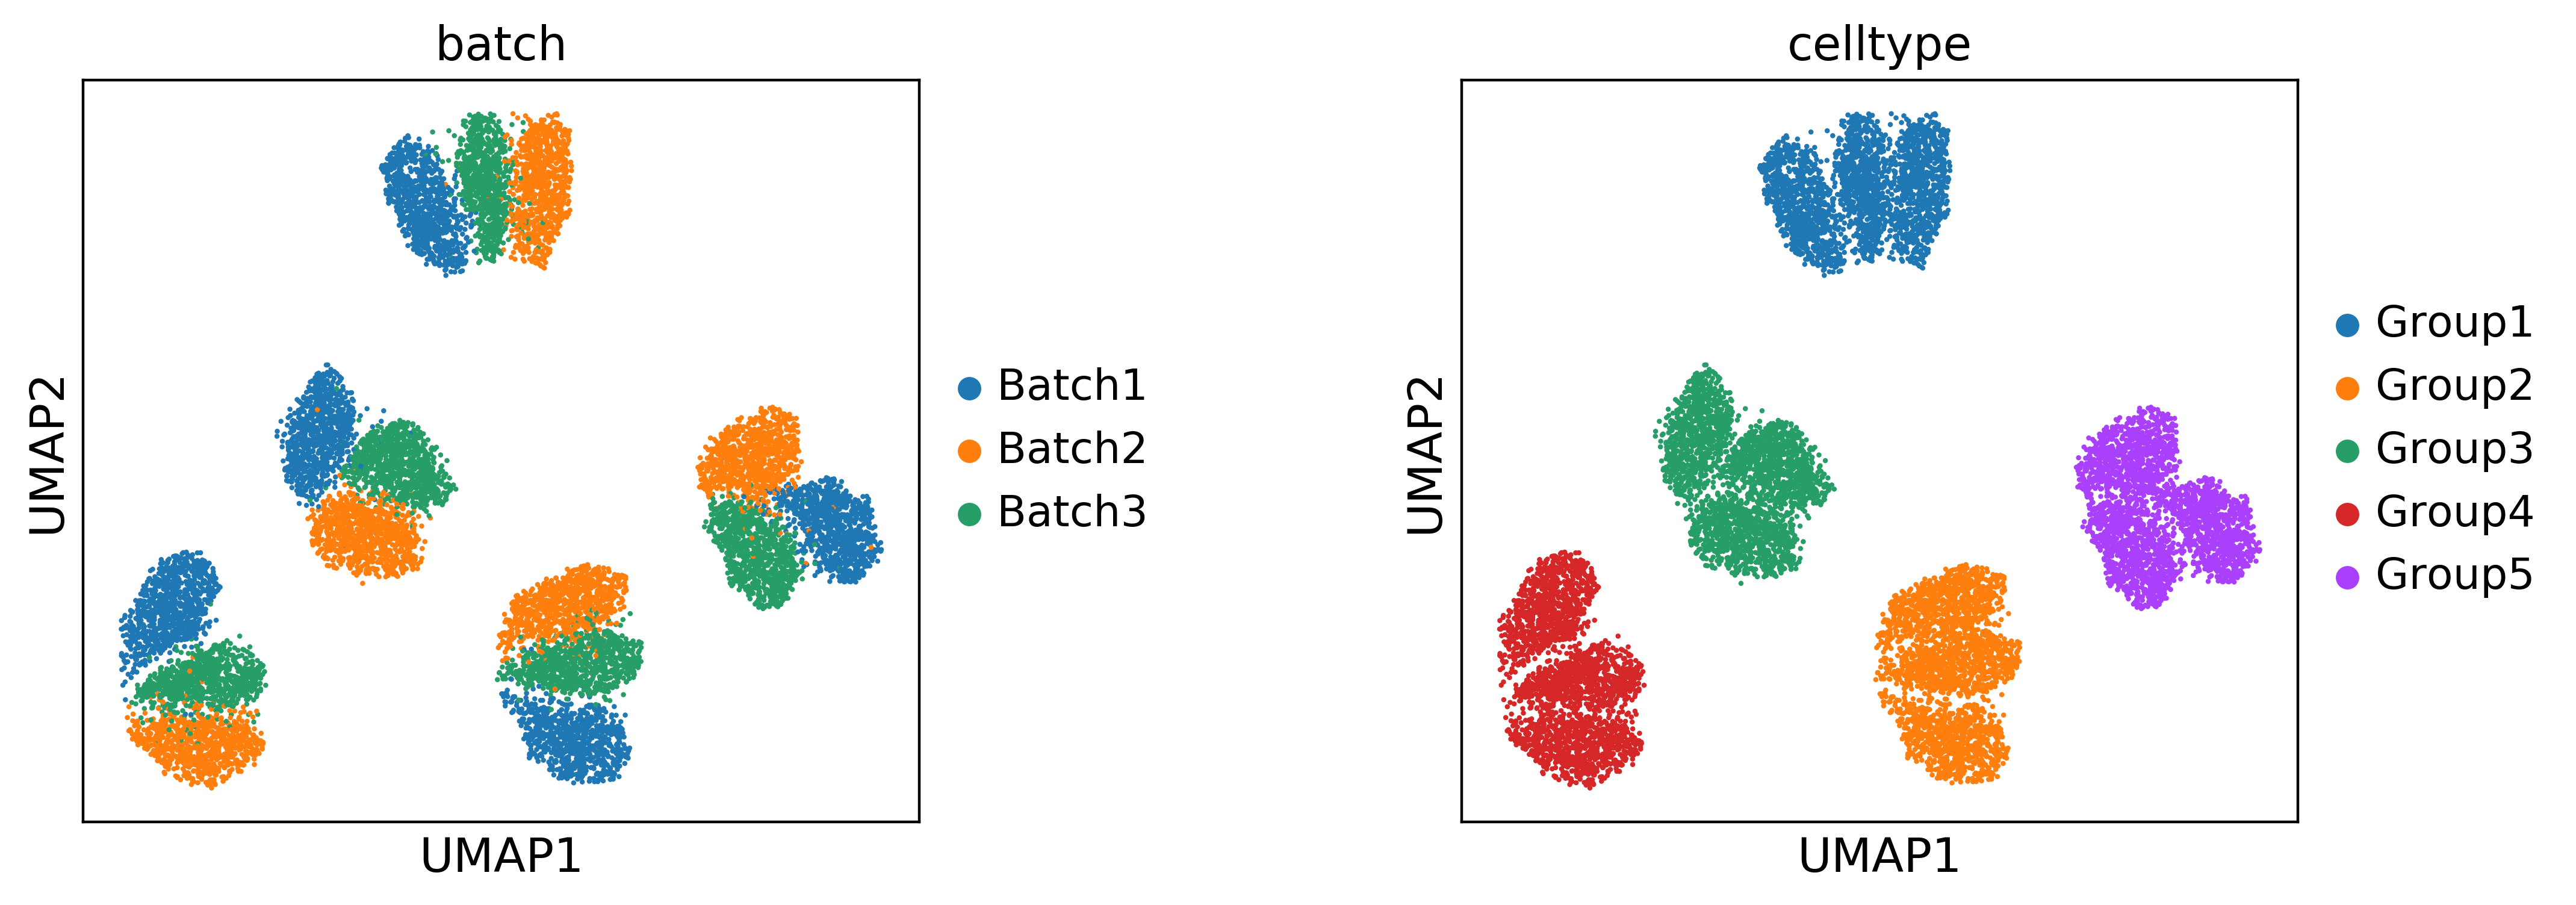

In [22]:
sc.pl.umap(latent_adata, color=[condition_key, cell_type_key], wspace=0.5)

# Perfroming architecture Surgery

In [23]:
new_network = surgeon.operate(network, 
                              new_condition=target_condition,
                              init='Xavier', 
                              freeze=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 2000)         0                                            
__________________________________________________________________________________________________
encoder_labels (InputLayer)     (None, 4)            0                                            
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, 2004)         0           data[0][0]                       
                                                                 encoder_labels[0][0]             
__________________________________________________________________________________________________
first_layer (Dense)             (None, 512)          1026048     concatenate_3[0][0]              
__________

In [24]:
new_network.condition_encoder

{'Batch1': 0, 'Batch2': 1, 'Batch3': 2, 'Batch4': 3}

## Train with small new dataset containing out-of-sample condition

In [25]:
train_adata, valid_adata = surgeon.utils.train_test_split(adata_out_of_sample, 0.85)

In [26]:
train_adata.shape, valid_adata.shape

((4250, 2000), (750, 2000))

In [27]:
new_network.train(train_adata,
                  valid_adata, 
                  condition_key=condition_key,
                  le=new_network.condition_encoder, 
                  n_epochs=100,
                  batch_size=128, 
                  early_stop_limit=25,
                  lr_reducer=20, 
                  save=True, 
                  verbose=2)

Train on 4250 samples, validate on 750 samples
Epoch 1/100
 - 1s - loss: 280.5482 - kl_recon_loss: 280.5482 - val_loss: 274.0407 - val_kl_recon_loss: 274.0407
Epoch 2/100
 - 0s - loss: 279.0808 - kl_recon_loss: 279.0808 - val_loss: 274.9247 - val_kl_recon_loss: 274.9247
Epoch 3/100
 - 0s - loss: 278.2411 - kl_recon_loss: 278.2411 - val_loss: 278.7168 - val_kl_recon_loss: 278.7168
Epoch 4/100
 - 0s - loss: 277.7246 - kl_recon_loss: 277.7246 - val_loss: 275.2064 - val_kl_recon_loss: 275.2064
Epoch 5/100
 - 0s - loss: 277.6592 - kl_recon_loss: 277.6592 - val_loss: 275.1249 - val_kl_recon_loss: 275.1249
Epoch 6/100
 - 0s - loss: 277.5351 - kl_recon_loss: 277.5351 - val_loss: 273.7723 - val_kl_recon_loss: 273.7723
Epoch 7/100
 - 0s - loss: 277.4498 - kl_recon_loss: 277.4498 - val_loss: 272.6728 - val_kl_recon_loss: 272.6728
Epoch 8/100
 - 0s - loss: 277.4017 - kl_recon_loss: 277.4017 - val_loss: 272.4906 - val_kl_recon_loss: 272.4906
Epoch 9/100
 - 0s - loss: 277.2840 - kl_recon_loss: 277.2

In [28]:
encoder_labels, _ = surgeon.utils.label_encoder(adata, label_encoder=new_network.condition_encoder, condition_key=condition_key)

In [29]:
adata.obs[condition_key].value_counts()

Batch4    5000
Batch3    5000
Batch2    5000
Batch1    5000
Name: batch, dtype: int64

In [30]:
latent_adata = new_network.to_latent(adata, encoder_labels)
latent_adata

AnnData object with n_obs × n_vars = 20000 × 20 
    obs: 'batch', 'celltype', 'n_counts'

In [31]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

/home/mohsen/.local/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


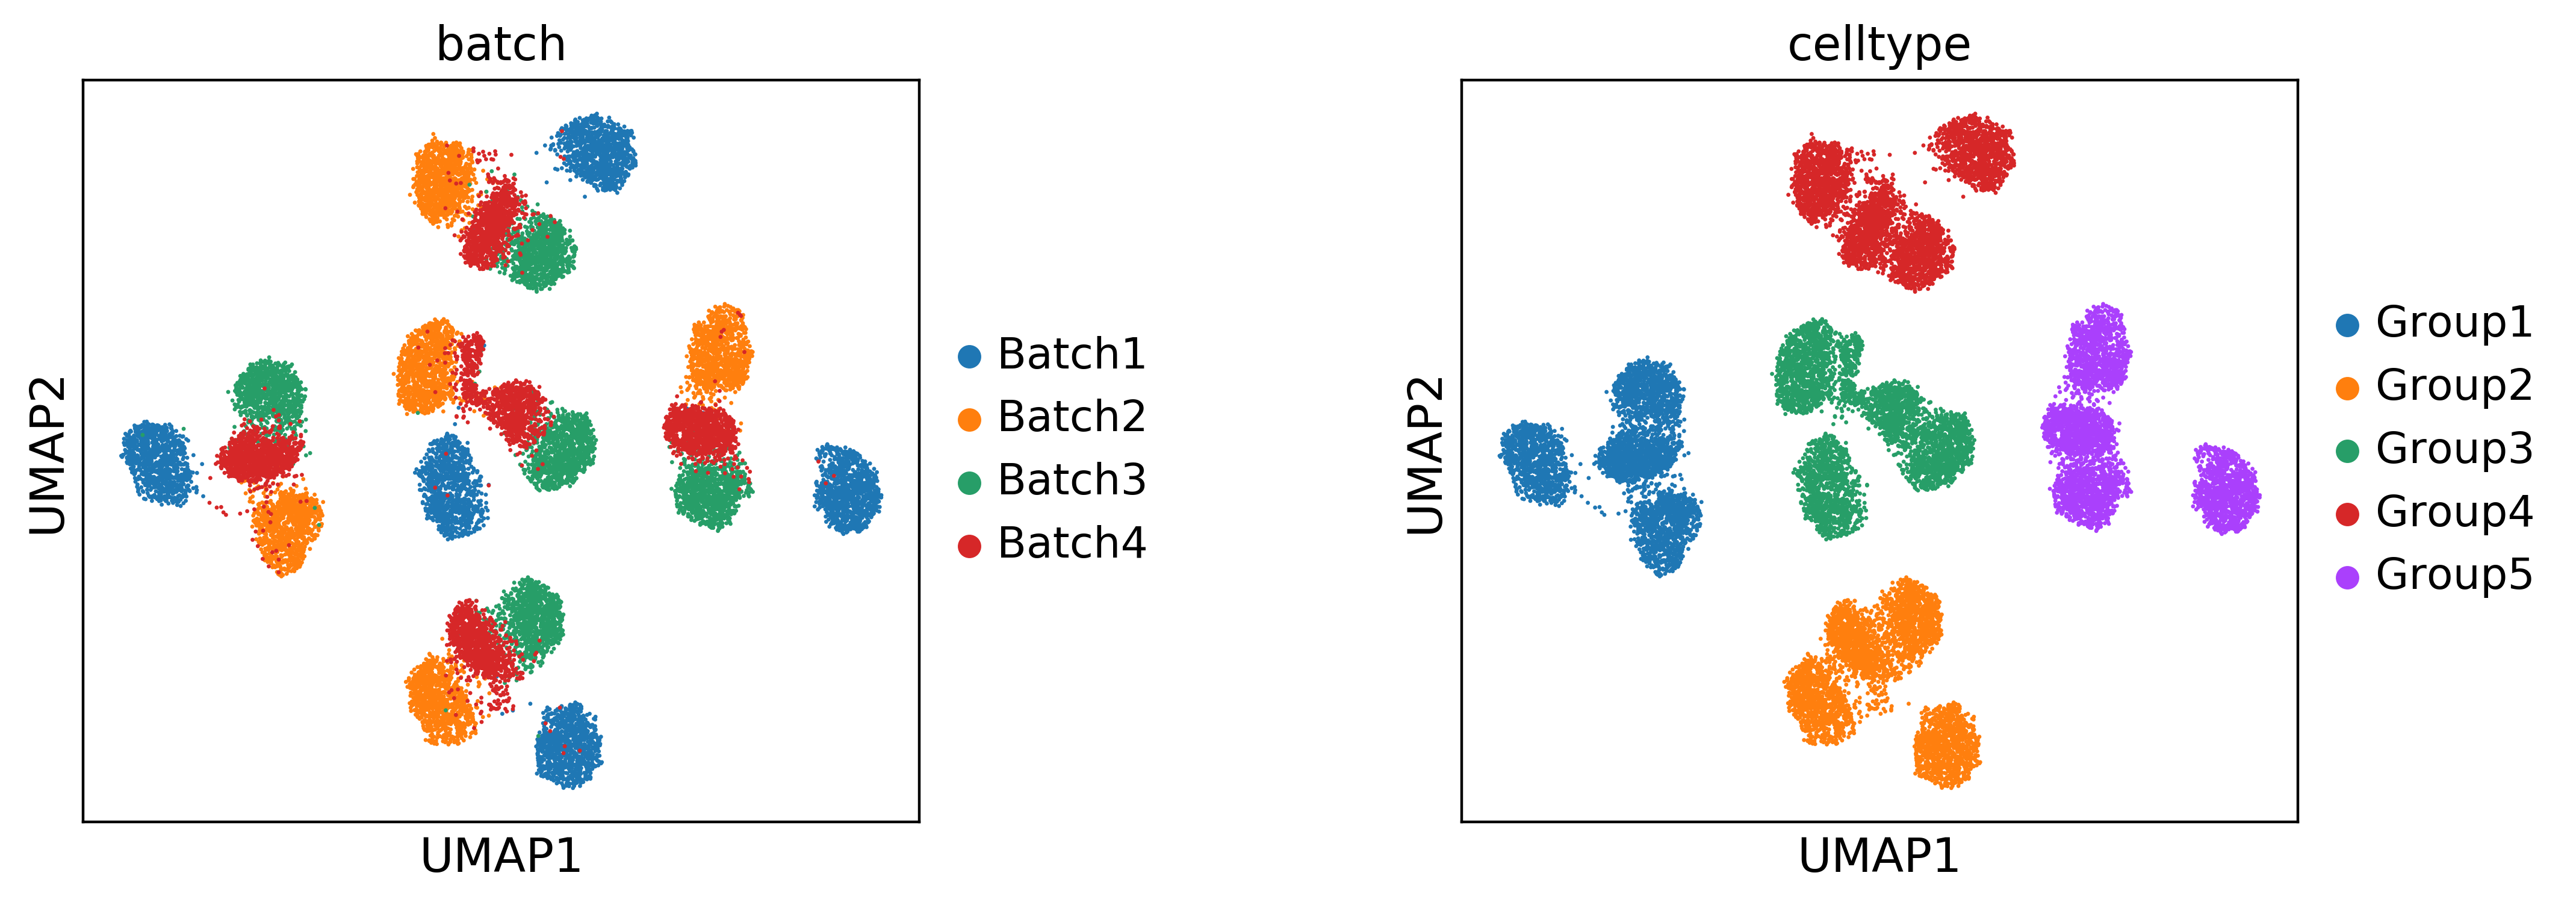

In [32]:
sc.pl.umap(latent_adata, color=[condition_key, cell_type_key], wspace=0.5)